In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.regression.rolling import RollingOLS

In [122]:
# --- 1. Get Data ---
period = '5y'
EURUSD_TICKER = 'EURUSD=X'
EURUSD_DATA = yf.Ticker(EURUSD_TICKER).history(period=period)['Close']
GBPUSD_TICKER = 'GBPUSD=X'
GBPUSD_DATA = yf.Ticker(GBPUSD_TICKER).history(period=period)['Close']

In [130]:


# Download the closing prices
# stock_data = yf.Ticker(stock_ticker).history(start=start_date, end=end_date)['Close']
# market_data = yf.Ticker(market_ticker).history(start=start_date, end=end_date)['Close']
pair_1_data = EURUSD_DATA.copy()
pair_2_data = GBPUSD_DATA.copy()
pair_1_data.index = pair_1_data.index.date
pair_2_data.index = pair_2_data.index.date

# Combine into one DataFrame and drop any missing (e.g., holiday)
# df = pd.DataFrame({'stock': stock_data, 'market': market_data}).dropna()
df = pd.DataFrame({'pair_1': pair_1_data, 'pair_2': pair_2_data}).dropna()


--- Cointegration Test on Rolling Spread (Window=60) ---
ADF Test p-value: 0.0000
Result: The pair IS cointegrated. The model is valid.



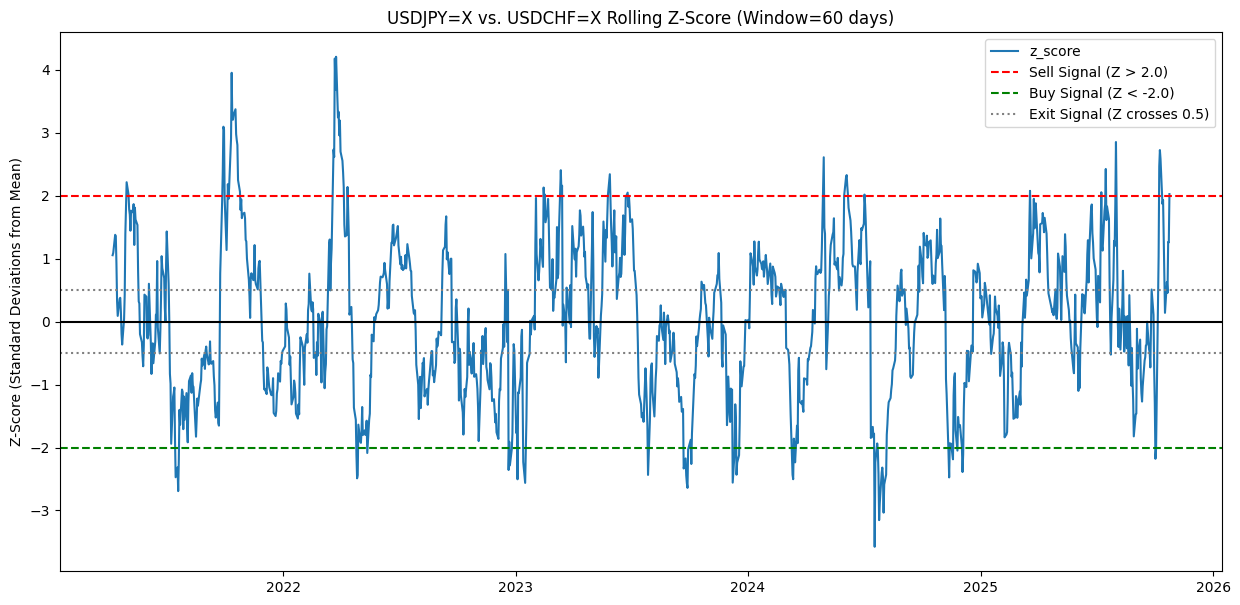

In [ ]:
df = pd.DataFrame({'stock': stock_data, 'market': market_data}).dropna()

# --- 2. Define Your "Tuning" Parameters ---
# KNOB 1: The Lookback Window (in days)
# Try 60, 120, 252 (trading days in a year)
window = 60

# KNOB 2: The Z-Score Thresholds for Entry/Exit
# Try 1.5, 2.0, 2.5
entry_threshold = 2.0
exit_threshold = 0.5 

# --- 3. Calculate the Rolling Hedge Ratio (Beta) ---
# We use log-prices to model the *percentage* relationship, which is more stable
y = np.log(df['stock'])
X = sm.add_constant(np.log(df['market'])) # Add a constant for the intercept (alpha)

# This runs an OLS regression for *every* 'window'-day period
rolling_model = RollingOLS(y, X, window=window)
rolling_fit = rolling_model.fit()

# --- THIS IS THE FIX ---
# Get the rolling parameters from the fit
rolling_params = rolling_fit.params
alpha = rolling_params['const']
beta = rolling_params['market']

# Manually calculate the spread (the residual)
# spread = y - (alpha + beta * X['market'])
spread = np.log(df['stock']) - (alpha + beta * np.log(df['market']))

# --- 4. Calculate the Rolling Z-Score (The Signal) ---
# We now calculate the Z-Score *of the spread*
rolling_mean = spread.rolling(window=window).mean()
rolling_std = spread.rolling(window=window).std()

df['z_score'] = (spread - rolling_mean) / rolling_std

# Drop the initial NaN values created by the rolling windows
df.dropna(inplace=True)

# --- 5. (Optional but Recommended) Check Cointegration ---
# Now that we have the final spread, let's test it
adf_result = adfuller(spread.dropna())
p_value = adf_result[1]

print(f"--- Cointegration Test on Rolling Spread (Window={window}) ---")
print(f"ADF Test p-value: {p_value:.4f}")
if p_value < 0.05:
    print("Result: The pair IS cointegrated. The model is valid.\n")
else:
    print("Result: WARNING! The pair is NOT cointegrated.\n")

# --- 6. Visualize the Tuned Model ---
plt.figure(figsize=(15, 7))
df['z_score'].plot()

plt.axhline(entry_threshold, color='red', linestyle='--', label=f'Sell Signal (Z > {entry_threshold})')
plt.axhline(-entry_threshold, color='green', linestyle='--', label=f'Buy Signal (Z < -{entry_threshold})')
plt.axhline(exit_threshold, color='gray', linestyle=':', label=f'Exit Signal (Z crosses {exit_threshold})')
plt.axhline(-exit_threshold, color='gray', linestyle=':')
plt.axhline(0.0, color='black', linestyle='-')

plt.title(f'{stock_ticker} vs. {market_ticker} Rolling Z-Score (Window={window} days)')
plt.ylabel('Z-Score (Standard Deviations from Mean)')
plt.legend()
plt.show()

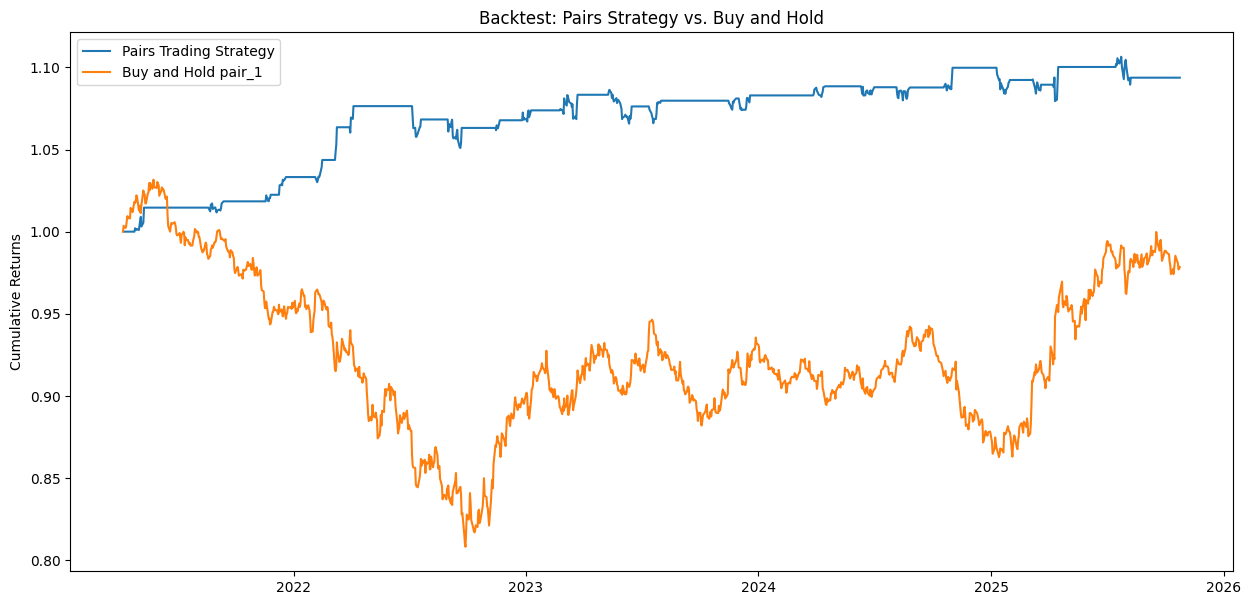

In [131]:
df = pd.DataFrame({'pair_1': pair_1_data, 'pair_2': pair_2_data}).dropna()

# Use log prices for a more stable relationship
df['log_price_1'] = np.log(df['pair_1'])
df['log_price_2'] = np.log(df['pair_2'])

# --- 2. Define Your "Tuning" Parameters ---
window = 60 # Lookback window (in days)
entry_threshold = 2.0
exit_threshold = 0.5 
stop_loss_threshold = 4

# --- 3. Calculate the Rolling Hedge Ratio (Beta) & Spread ---
y = df['log_price_1']
X = sm.add_constant(df['log_price_2']) # Add a constant for the intercept (alpha)

rolling_model = RollingOLS(y, X, window=window)
rolling_fit = rolling_model.fit()
rolling_params = rolling_fit.params

# Get the rolling alpha and beta (hedge ratio)
alpha = rolling_params['const']
beta = rolling_params['log_price_2'] # This is our hedge ratio
df['beta'] = beta # Save it for our returns calculation

# Calculate the spread (the divergence)
spread = df['log_price_1'] - (alpha + beta * df['log_price_2'])

# --- 4. Calculate the Rolling Z-Score (The Signal) ---
rolling_mean = spread.rolling(window=window).mean()
rolling_std = spread.rolling(window=window).std()

df['z_score'] = (spread - rolling_mean) / rolling_std

# Drop all NaNs created by the rolling windows
df.dropna(inplace=True)

# --- 5. Generate Positions with a Loop (State-Based) ---
df['position'] = 0  # 0=Flat, 1=Long Spread, -1=Short Spread
current_position = 0

for i in range(len(df)):
    z_score = df['z_score'].iloc[i]
    
    # --- Logic for when we are FLAT (0) ---
    if current_position == 0:
        if z_score < -entry_threshold:
            current_position = 1  # Buy Spread (Long Pair 1, Short Pair 2)
        elif z_score > entry_threshold:
            current_position = -1 # Sell Spread (Short Pair 1, Long Pair 2)
            
    # --- Logic for when we are LONG SPREAD (1) ---
    elif current_position == 1:
        if z_score >= -exit_threshold: # Profit-take
            current_position = 0
        elif z_score < -stop_loss_threshold: # Stop-loss
            current_position = 0
            
    # --- Logic for when we are SHORT SPREAD (-1) ---
    elif current_position == -1:
        if z_score <= exit_threshold: # Profit-take
            current_position = 0
        elif z_score > stop_loss_threshold: # Stop-loss
            current_position = 0
            
    df.iloc[i, df.columns.get_loc('position')] = current_position

# --- 6. Calculate Strategy Returns (Corrected Hedged Method) ---
df['position'] = df['position'].shift(1) # Shift position by 1 day

# Calculate the daily returns for each pair
df['pair_1_returns'] = df['log_price_1'].diff()
df['pair_2_returns'] = df['log_price_2'].diff()

# --- THIS IS THE CRITICAL CORRECTION ---
# Your strategy return is the return of your long leg minus the return of your short leg.
# The hedge ratio (beta) must be used.
# position = 1 means: +1 * (return_1) - beta * (return_2)
# position = -1 means: -1 * (return_1) + beta * (return_2)
# This simplifies to:
df['strategy_returns'] = df['position'] * (df['pair_1_returns'] - df['beta'] * df['pair_2_returns'])

# --- 7. Calculate Cumulative Returns (Equity Curve) ---
# We also compare to just buying and holding Pair 1
df['buy_and_hold_returns'] = df['pair_1_returns'].fillna(0)

cumulative_strategy_returns = df['strategy_returns'].cumsum().apply(np.exp)
cumulative_buy_and_hold_returns = df['buy_and_hold_returns'].cumsum().apply(np.exp)

# --- 8. Plot the Final Performance Test ---
plt.figure(figsize=(15, 7))
cumulative_strategy_returns.plot(label='Pairs Trading Strategy')
cumulative_buy_and_hold_returns.plot(label=f'Buy and Hold pair_1')
plt.title('Backtest: Pairs Strategy vs. Buy and Hold')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

In [76]:
# --- 2. Split into Training and Testing Sets ---
# We use the first 70% of the data to *find* the relationship
# We use the last 30% to *trade* on it
split_index = int(len(df) * 0.7)
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

print(f"Training data from {train_df.index.min()} to {train_df.index.max()}")
print(f"Testing data from {test_df.index.min()} to {test_df.index.max()}")

Training data from 2020-10-26 to 2024-04-22
Testing data from 2024-04-23 to 2025-10-24


In [77]:
# --- 3. Find the Hedge Ratio (Beta) on Training Data ---
# We use OLS (Ordinary Least Squares) regression
y = train_df['stock']
X = sm.add_constant(train_df['market']) # Add a constant for the intercept (alpha)

model = sm.OLS(y, X).fit()
beta = model.params['market']
alpha = model.params['const']

print(f"\n--- Step 1: Find Relationship ---")
print(f"Hedge Ratio (Beta): {beta:.4f}")
print(f"Alpha: {alpha:.4f}")


--- Step 1: Find Relationship ---
Hedge Ratio (Beta): 1.0971
Alpha: 0.0694


In [80]:
# --- 4. Test for Cointegration on Training Data ---
# We check if the "spread" (the divergence) is stationary
spread_train = train_df['stock'] - beta * train_df['market']
adf_result = adfuller(spread_train)
p_value = adf_result[1]
p_threshold = 0.1
print(f"\n--- Step 2: Test for Cointegration ---")
print(f"ADF Test p-value: {p_value:.4f}")

if p_value < p_threshold:
    print(f"Result: The pair IS cointegrated (p-value < {p_threshold}).")
    print("This strategy is valid. We can proceed.\n")
else:
    print(f"Result: The pair is NOT cointegrated (p-value >= {p_threshold}).")
    print("STOP HERE. This strategy will not work for this pair.\n")
    # In a real script, you would exit here
    # For this example, we'll proceed so you can see the (bad) chart


--- Step 2: Test for Cointegration ---
ADF Test p-value: 0.0580
Result: The pair IS cointegrated (p-value < 0.1).
This strategy is valid. We can proceed.



In [72]:
# --- 5. Calculate Z-Score (The Signal) on Test Data ---
# We must use the mean and std from the TRAINING data.
# This prevents any look-ahead bias.
spread_mean = spread_train.mean()
spread_std = spread_train.std()

print(f"--- Step 3: Calculate Z-Score ---")
print(f"Long-Term Spread Mean (from training): {spread_mean:.4f}")
print(f"Long-Term Spread Std Dev (from training): {spread_std:.4f}")

# Now, calculate the spread and Z-Score for the *test* data
spread_test = test_df['stock'] - beta * test_df['market']
test_df['z_score'] = (spread_test - spread_mean) / spread_std

--- Step 3: Calculate Z-Score ---
Long-Term Spread Mean (from training): 12.7112
Long-Term Spread Std Dev (from training): 1.9215


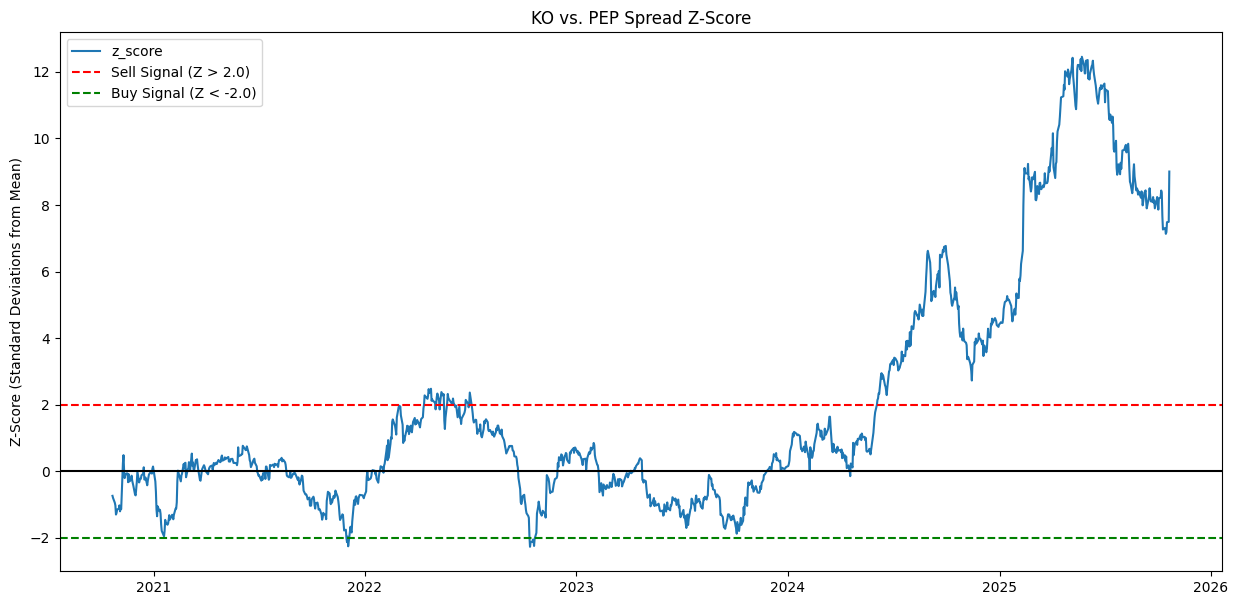

In [73]:
# --- 6. Visualize the Divergence and Signals ---
plt.figure(figsize=(15, 7))
test_df['z_score'].plot()

# Add the signal lines (e.g., at 2.0 and -2.0)
plt.axhline(2.0, color='red', linestyle='--', label='Sell Signal (Z > 2.0)')
plt.axhline(-2.0, color='green', linestyle='--', label='Buy Signal (Z < -2.0)')
plt.axhline(0.0, color='black', linestyle='-')

plt.title(f'{stock_ticker} vs. {market_ticker} Spread Z-Score')
plt.ylabel('Z-Score (Standard Deviations from Mean)')
plt.legend()
plt.show()